Illustrate regridding of 2-D data from one lat-lon grid to another
==================


- Reads the monthly mean SST data (here we use NOAA's OISST V2). The data is provided on a 1x1 degre lat-lon grid 

- Reads the monthly mean Sea Level Pressure field from NCEP Reanalysis (NCEP2) available on a 2.5x2.5 degree  lat-lon grid

- Interpolates the SST data to the NCEP grid 

- Assumes that the data are already downloaded. The example data here are easily obtained from NOAA ESRL website

In [3]:
import sys
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time

# for interpolation
from geocat.comp import linint2
import cartopy.crs as ccrs

from cartopy.mpl.geoaxes import GeoAxes
from matplotlib import cm
from mpl_toolkits.axes_grid1 import AxesGrid

import geocat.viz.util as gvutil


In [4]:
# sst
sstData ='/home/anant/data100/data/sst/oisstV2/sst.mnmean.nc'
# load and view netcdf file
ds  = xr.open_dataset(sstData)

# subset sst over years needed 
sst = ds.sst.sel(time=slice('2020','2020')).chunk()
sst = sst.reindex(lat=sst.lat[::-1])
lat = sst.lat[:]
lon = sst.lon[:]




In [3]:
# optional create a seasonal climatology and show plot
#clim = sst.sel(time=slice('1995','2019')).groupby('time.season').mean(dim='time')
#clim.sel(season='DJF').plot()

### Suppose one wants a monthly timeseries of global average SST 
### We now see how the results vary if we do not weigh the grid points by their area

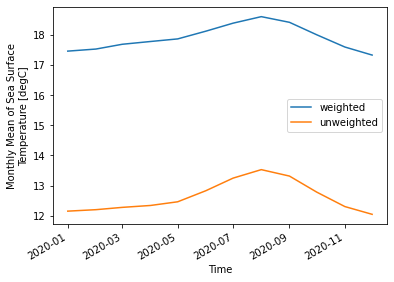

In [5]:
#  weighted mean
weights = np.cos(np.deg2rad(sst.lat))
weights.name = "weights"
sst_weighted = sst.weighted(weights).mean(("lon", "lat"))
sst_weighted.plot(label="weighted")
sst.mean(("lon", "lat")).plot(label="unweighted")
plt.legend()

### Now back to our interpolation

In [14]:
# read the NCEP data for the lat lon coords
fileName = '/home/anant/data100/data/ncep2/mslp.mon.mean.nc'
ds   = xr.open_dataset(fileName)

## Use the geocat-comp package to perform the grid to grid interpolation

#print(ds.lon)

# Invoke `linint2` from `geocat.comp`
newsst = linint2(sst,ds.lon,ds.lat[::-1], icycx=False)


[28.97999954 28.59499931 29.29500008 29.19499969 28.61999893 25.87999916
 25.12999916 24.59000015 24.49499893 25.46999931 26.20499992 26.93999863]


# Verify that the global mean weighted SST is conserved after regridding

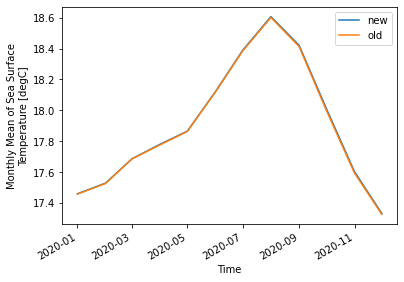

In [6]:
# Now create an area-weighted global average
newsst_weighted = newsst.weighted(weights).mean(("lon", "lat"))
newsst_weighted.plot(label="new")
sst_weighted.plot(label="old")
plt.legend()

## Verify that the differences are small

0.0008139766345927058 0.01149333819579823


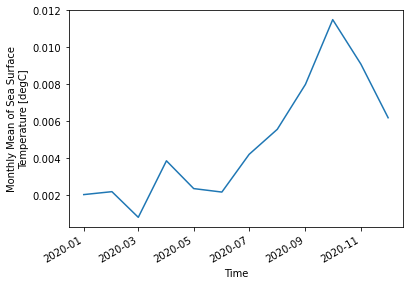

In [14]:
diff = newsst_weighted - sst_weighted
diff.plot()

print (min(diff.values), max(diff.values))

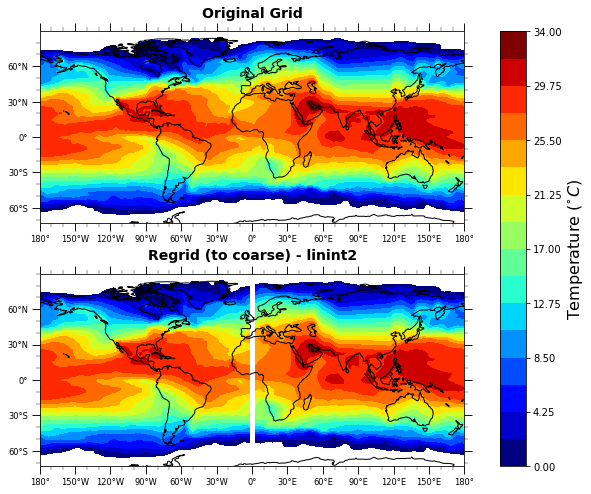

In [17]:
# Generate figure and set its size (width, height) in inches
fig = plt.figure(figsize=(10, 8))

# Generate Axes grid using a Cartopy projection
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
axgr = AxesGrid(fig,
                111,
                axes_class=axes_class,
                nrows_ncols=(2, 1),
                axes_pad=0.7,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.5,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode

# Create a dictionary for common plotting options for both subplots
plot_options = dict(transform=projection,
                    cmap=cm.jet,
                    vmin=0,
                    vmax=34,
                    levels=17,
                    extend='neither',
                    add_colorbar=False,
                    add_labels=False)

# Plot original grid and linint2 interpolations as two subplots
# within the figure
for i, ax in enumerate(axgr):

    # Plot contours for both the subplots
    if (i == 0):
        sst[6,:,:].plot.contourf(ax=ax, **plot_options)
        ax.set_title('Original Grid', fontsize=14, fontweight='bold', y=1.04)
    else:
        p=newsst[6,:,:].plot.contourf(ax=ax, **plot_options)
        ax.set_title('Regrid (to coarse) - linint2',
                     fontsize=14,
                     fontweight='bold',
                     y=1.04)

    # Add coastlines to the subplots
    ax.coastlines()

    # Use geocat.viz.util convenience function to add minor and major tick
    # lines
    gvutil.add_major_minor_ticks(ax)

    # Use geocat.viz.util convenience function to set axes limits & tick
    # values without calling several matplotlib functions
    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(-180, 180, 13),
                                     yticks=np.linspace(-60, 60, 5))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gvutil.add_lat_lon_ticklabels(ax, zero_direction_label=False)

# Add color bar and label details (title, size, etc.)
cax = axgr.cbar_axes[0]
cax.colorbar(p)
axis = cax.axis[cax.orientation]
axis.label.set_text(r'Temperature ($^{\circ} C$)')
axis.label.set_size(16)
axis.major_ticklabels.set_size(10)

plt.show()